In [20]:
# Imports for the Maptek Python SDK and additional libraries.
import time

import matplotlib as mpl
import matplotlib.colors as cc

# mpl.use('agg')
import matplotlib.pyplot as cm
from mapteksdk.data import (
    DenseBlockModel,
    GridSurface,
    NumericColourMap,
    SubblockedBlockModel,
    Surface,
    Text3D,
)
from mapteksdk.project import Project
from matplotlib.ticker import PercentFormatter
from matplotlib.widgets import Button, CheckButtons, RadioButtons

time.sleep(2)

import copy
import ctypes
import math
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm.rcParams["font.family"] = ["Source Han Sans TW", "monospace"]
cm.rcParams["font.size"] = 14

# Connect to the currently running Maptek Project.
project = Project()
# project.mcp_instance.mcp_dict['PRODUCT_LOCATION_INFO']  # Report out which application it connected to (Optional)

In [28]:
# Initialisation
selected_model = None
selected_var = ""
colours = ""
real_colours = []
vis = ""
# ****************Bool swicthes for certain features*****************************************************************
vis_compiler = False
point_checker = True
# ********************************************************************************************************************
names = []
df = pd.DataFrame()
selection = project.get_selected()
last_opacity = 255

# For getting colours and the mapped names used in the model visualisation
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
with project.edit("legends/Domain") as legend:
    colours = legend.colours
    colour_names = legend.legend
    colour_names = [each_string.lower() for each_string in colour_names]
# Getting hex values of the colours
colours = colours / 255
for z in range(0, len(colour_names), 1):
    real_colours.append(cc.to_hex(colours[z], keep_alpha=True))

# Creating the array for storing data to be retrieved
N = len(colour_names)
M = len(selection)
values = [[0 for i in range(M)] for j in range(N)]
vis_collection = [0] * M
var_collection = [0] * M
i = 0
j = 0


# DATA GETTER
for item in selection:
    print(item.name)
    # Setting outer array back to 0, for new block
    j = 0
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        selected_model = item
        with project.read(selected_model) as bm:
            # Checker for point stuff
            if point_checker:
                # Getting all block details
                block_sizes = bm.block_sizes
                block_centroids = bm.block_centroids
                b = bm.block_resolution
                x_res = b[0]
                y_res = b[1]
                z_res = b[2]
                x_count = bm.column_count
                y_count = bm.row_count
                z_count = bm.slice_count
                index_map = bm.block_to_grid_index
                index_map = index_map.tolist()
                # Converting from world coordinates
                block_centroids = bm.convert_to_block_coordinates(block_centroids)
                block_centroids = block_centroids + 0.5 * block_sizes[0]
                # Getting sample point data for point to block comparison
                with project.read("samples/res Intervals Table mid points") as points:
                    # SDK method
                    real_points = points.points
                    real_points = bm.convert_to_block_coordinates(real_points)
                    real_points = real_points + 0.5 * block_sizes[0]
                    point_collection = [0] * len(real_points)
                    point_domains = points.point_attributes[
                        '{"c":"Domain","n":[],"s":"Point attribute (text)","t":"Tstring","u":"dimensionless","v":3}'
                    ]
            # *************************************************************************************************
            # Brute-force method
            extents = [[]] * len(selection)
            print("Calculating block extents")
            for nn in range(0, len(block_centroids), 1):
                extents[i].append(
                    np.array(
                        [
                            block_centroids[nn] - block_sizes[nn] / 2,
                            block_centroids[nn] + block_sizes[nn] / 2,
                        ]
                    )
                )
            extents = np.array(extents)
            # *************************************************************************************************
            # # Checks all attributes of block and then chooses the one with discrete values
            a_dict = bm.block_attributes.names
            for key in a_dict:
                checker = bm.block_attributes[key]
                if isinstance(checker[0], (str, int)):
                    selected_var = checker
                    var_collection[i] = selected_var
            vis = bm.block_visibility
            vis_collection[i] = vis
            for domain in colour_names:
                values[j][i] = np.count_nonzero(selected_var == domain)
                j = j + 1
            # Creating labels
            names.append("Block" + str(i))
            # For the confusion matrix
            df["block" + str(i)] = pd.Series(selected_var)
            i = i + 1

# Visibility filterer
if vis_compiler:
    visfinal = vis_collection[0]
    for q in range(1, len(vis_collection), 1):
        visfinal = visfinal & vis_collection[q]

    # The statement below removes all values in selected_var which have a corresponding false value
    # in the same index location in vis
    for z in range(0, len(var_collection), 1):
        var_collection[z] = np.array(var_collection[z])[visfinal]

    for d in range(0, M, 1):
        # For the confusion matrix
        df["block" + str(d)] = pd.Series(var_collection[d])
        for domain, k in zip(colour_names, range(0, len(colour_names), 1)):
            values[k][d] = np.count_nonzero(var_collection[d] == domain)
# For the confusion matrix
df.dropna(inplace=True)

Subblocked 14-12-2021 11:05
Calculating block extents


In [18]:
print(np.array(selected_var))
print(len(point_domains))
print(len(index_map))
print(real_points)
print(block_centroids)

['pr' 'pr' 'pr' ... 'ox' 'ox' 'ox']
3847
5384498
[[ 61.93328093 200.69343549 118.7244873 ]
 [ 61.4332938  200.68984887 117.85846189]
 [ 60.93330666 200.68626225 116.99243649]
 ...
 [ 55.87280404 298.46247763 108.58711894]
 [ 55.3728169  298.45889101 107.72109354]
 [ 54.9728271  298.45602171 107.02827305]]
[[183.75   136.5     -0.375 ]
 [183.75   137.0625  -0.375 ]
 [183.375  137.4375  -0.375 ]
 ...
 [336.75   304.875  124.6875]
 [338.25   304.875  124.6875]
 [339.75   304.875  124.6875]]


In [31]:
# POINT TO BLOCK/SUB-BLOCK COMPARISON
point_pos1 = []
domains_of_blocks = []
outside_count = 0
outside_indices = []
cx1 = 0
for cx1 in range(0, len(real_points), 1):
    c1 = math.floor(real_points[cx1][0] / x_res)
    c2 = math.floor(real_points[cx1][1] / y_res)
    c3 = math.floor(real_points[cx1][2] / z_res)
    with project.read(selected_model) as bm:
        if c1 < x_count and c2 < y_count and c3 < z_count:
            index = index_map.index([c1, c2, c3])

            subblock_check = bm.grid_index(index)
            subblock_indices = np.where(subblock_check)[0]
            if len(subblock_indices) > 1:
                for ex in subblock_indices:
                    if (
                        (
                            extents[0][ex][0][0]
                            < real_points[cx1][0]
                            <= extents[0][ex][1][0]
                        )
                        and (
                            extents[0][ex][0][1]
                            < real_points[cx1][1]
                            <= extents[0][ex][1][1]
                        )
                        and (
                            extents[0][ex][0][2]
                            < real_points[cx1][2]
                            <= extents[0][ex][1][2]
                        )
                    ):
                        point_pos1.append(ex)
                        domains_of_blocks.append(selected_var[ex])
                        break
            else:
                point_pos1.append(index)
                domains_of_blocks.append(selected_var[index])
        else:
            outside_count += 1
            outside_indices.append(cx1)
            continue

point_domains = [z.lower() for z in point_domains]
point_domains_wo_outliers = copy.deepcopy(point_domains)
for i in outside_indices:
    del point_domains_wo_outliers[i]

num_equal = sum(x == y for x, y in zip(point_domains_wo_outliers, domains_of_blocks))
print(num_equal)
print(subblock_check)
print(subblock_indices)

9
[False False False ... False False False]
[]


In [179]:
match_percentage = str(round(((num_equal * 100) / len(point_domains_wo_outliers)), 2))

print(
    "From "
    + str(len(point_domains_wo_outliers))
    + " points (excluding outliers, which were outside the block model) "
    + str(num_equal)
    + " points were in the same block with the same domain"
    + " hence having a match percentage of "
    + match_percentage
)

print("The number of unique points:" + str(len(point_domains_wo_outliers)))
print("The number of unique blocks:" + str(len(set(point_pos1))))

df["Points Domain"] = pd.Series(point_domains_wo_outliers)
df["Block Domains"] = pd.Series(domains_of_blocks)
print(
    "Below are counts of how these points are distributed in the sample and predicted model respectively"
)
print(df["Points Domain"].value_counts())
print(df["Block Domains"].value_counts())

From 3845 points (excluding outliers, which were outside the block model) 3507 points were in the same block with the same domain hence having a match percentage of 91.21
The number of unique points:3845
The number of unique blocks:2776
Below are counts of how these points are distributed in the sample and predicted model respectively
ox            1922
pr            1182
pox            705
undomained      26
cvt             10
Name: Points Domain, dtype: int64
ox            1894
pr            1244
pox            701
undomained       6
Name: Block Domains, dtype: int64


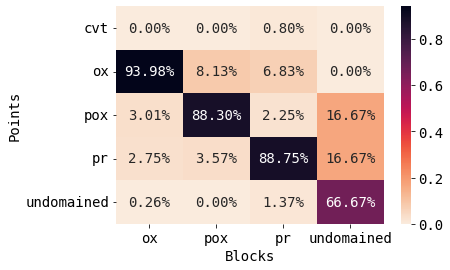

In [180]:
# CONFUSION MATRIX FOR POINT TO BLOCK COMPARISON
point_confusion_matrix = pd.crosstab(
    df["Points Domain"], df["Block Domains"], rownames=["Points"], colnames=["Blocks"]
)
point_confusion_matrix = pd.DataFrame(point_confusion_matrix)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix) / (np.sum(point_confusion_matrix)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=True,
)

cm.show()
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# )

In [50]:
# BRUTE FORCE METHOD
tr = 0
point_pos = {}
# THIS IS FOR TESTING ONLY, STILL HAVE TO TAKE ACCOUNT OF WHICH BLOCK MODEL WE ARE PARSING, IN THE CODE BELOW.
for cx in range(0, 5, 1):
    for ex in range(0, len(block_centroids), 1):
        if (
            (extents[0][ex][0][0] < real_points[cx][0] <= extents[0][ex][1][0])
            and (extents[0][ex][0][1] < real_points[cx][1] <= extents[0][ex][1][1])
            and (extents[0][ex][0][2] < real_points[cx][2] <= extents[0][ex][1][2])
        ):
            point_pos[cx] = ex
            tr = tr + 1
            break

print(tr)
print(point_pos)

5
{0: 3688791, 1: 3642482, 2: 3642482, 3: 3596174, 4: 3596173}


In [147]:
# TESTING STUFF
print("FOR SDK:")
for c_sdk in range(0, 5, 1):
    sdk = [block_centroids[point_pos1[c_sdk]]]
    print(sdk)

# for point in point_pos1:
#     print(block_centroids[point])


print("FOR BRUTE:")
print(block_centroids[point_pos[2]])
print(block_centroids[point_pos[4]])
# for c_brute in range(0,5,1):
#     brute=([block_centroids[point_pos[c_brute]]])
#     print(brute)

print("FOR POINTS:")
for c_point in range(0, 5, 1):
    pt = [real_points[c_point]]
    print(pt)

FOR SDK:
[array([ 62.25, 201.75, 120.75])]
[array([ 62.25, 201.75, 119.25])]
[array([ 62.25, 201.75, 117.75])]
[array([ 60.75, 201.75, 117.75])]
[array([ 60.75, 201.75, 116.25])]
FOR BRUTE:
[ 60.75 201.75 117.75]
[ 59.25 201.75 116.25]
FOR POINTS:
[array([ 61.93328093, 201.06843549, 119.2869873 ])]
[array([ 61.4332938 , 201.06484887, 118.42096189])]
[array([ 60.93330666, 201.06126225, 117.55493649])]
[array([ 60.43331953, 201.05767563, 116.68891109])]
[array([ 59.93333239, 201.054089  , 115.82288568])]


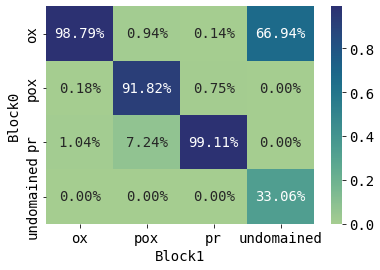

              precision    recall  f1-score   support

         cvt       1.00      1.00      1.00         0
          ox       0.99      0.98      0.99    616777
         pox       0.92      0.97      0.95    729311
          pr       0.99      0.97      0.98   2431091
  undomained       0.33      0.30      0.31       133

   micro avg       0.98      0.98      0.98   3777312
   macro avg       0.85      0.85      0.85   3777312
weighted avg       0.98      0.98      0.98   3777312



In [30]:
# ****************CONFUSION MATRIX*****************************************************************
confusion_matrix1 = pd.crosstab(
    df["block0"], df["block1"], rownames=["Block0"], colnames=["Block1"]
)
confusion_matrix1 = pd.DataFrame(confusion_matrix1)

# confusion_matrix2 = confusion_matrix(df['block0'], df['block1'])

mt = cm.figure(0)
gn = sns.heatmap(
    (confusion_matrix1) / (np.sum(confusion_matrix1)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="crest",
    cbar=True,
)

# ***************************JUST DIFFERENT COLOURS, PLEASE IGNORE*****************************************************************
# mt1=cm.figure(1)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="YlGnBu",cbar=True)
# mt2=cm.figure(2)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="rocket_r",cbar=True)
# mt3=cm.figure(3)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="cubehelix_r",cbar=True)
# colorbar =gn.collections[0].colorbar
# colorbar.set_ticks([0,20,40,60,80,100])
# ^^^^^^^^^^^^^^^^^^^JUST DIFFERENT COLOURS, PLEASE IGNORE^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# mt1=cm.figure(1)
# sns.heatmap(confusion_matrix2/np.sum(confusion_matrix2), annot=True, fmt=.2%', cbar=True,\
# cbar_kws={'format':PercentFormatter()}, cmap="Blues")

cm.show()
# Uncomment the lines below to generate a report.
print(
    metrics.classification_report(
        df["block0"], df["block1"], labels=colour_names, zero_division=1
    )
)

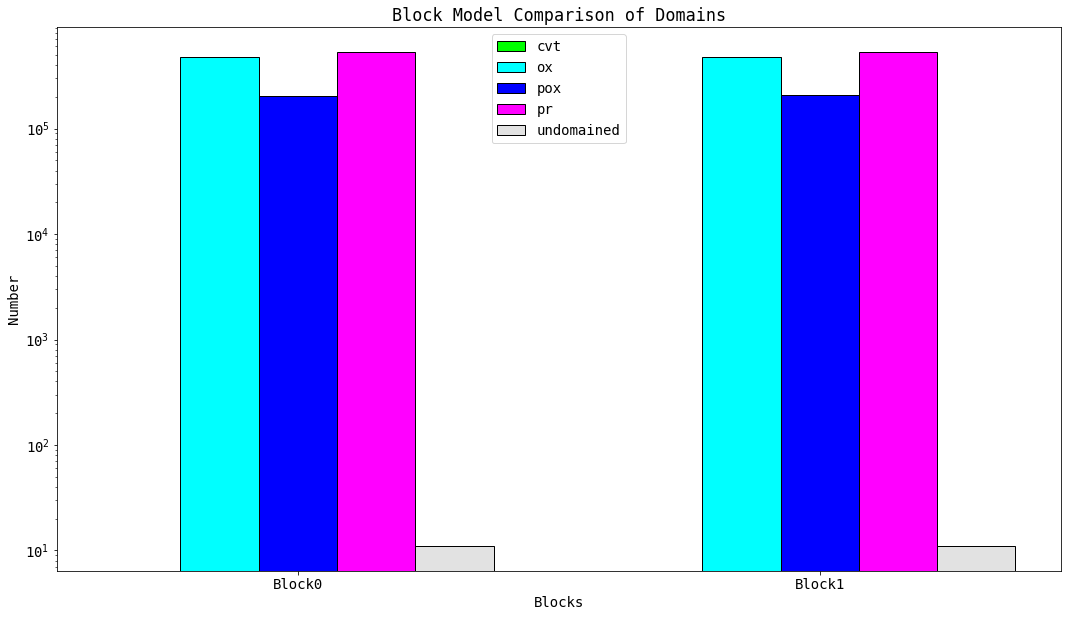

In [38]:
# *****************BAR PLOTS*****************************************************************
ind = np.arange(M)
width = 0.15
bar_names = {}

cm.figure(figsize=(18, 10))

for y in range(0, len(colour_names), 1):
    cm.bar(ind, values[y], width, color=real_colours[y], edgecolor="black", log=True)
    ind = ind + width

cm.xlabel("Blocks")
cm.ylabel("Number")
cm.title("Block Model Comparison of Domains")

cm.xticks(ind - 3 * width, names)
# cm.ticklabel_format(axis="y",style="plain")
cm.legend(colour_names)
cm.show()

# *************************************************************************************************

# seaborn stuff
# sns.barplot(names, values)

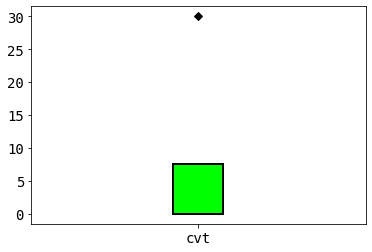

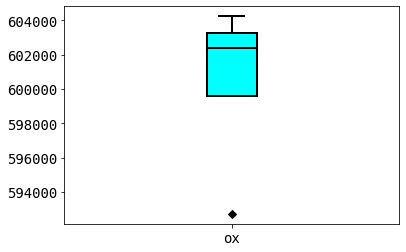

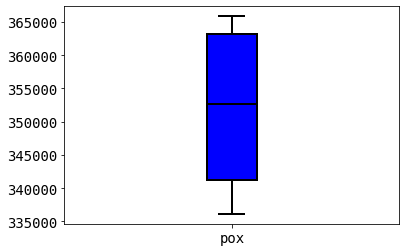

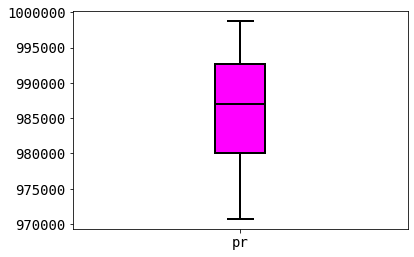

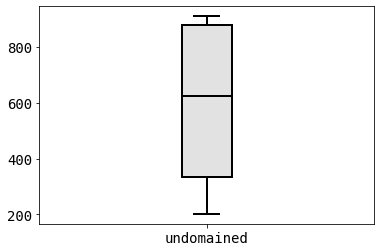

In [41]:
# *****************BOX PLOTS*****************************************************************

# This function sets up the properties of all plots
def setter(bp, c):

    for box in bp["boxes"]:
        box.set(color="#000000", linewidth=2)
        box.set(facecolor=c)

    for whisker in bp["whiskers"]:
        whisker.set(color="#000000", linewidth=2)

    for cap in bp["caps"]:
        cap.set(color="#000000", linewidth=2)

    for median in bp["medians"]:
        median.set(color="#000000", linewidth=2)

    for flier in bp["fliers"]:
        flier.set(marker="D", markerfacecolor="#000000", alpha=1)


# This function gets all the stats for the boxplots
def get_box_plot_data(bp):
    rows_list = []
    for i in range(len(colour_names)):
        dict1 = {}
        dict1["label"] = colour_names[i]
        dict1["lower_whisker"] = bp["whiskers"][i * 2].get_ydata()[1]
        dict1["lower_quartile"] = bp["boxes"][i].get_ydata()[1]
        dict1["median"] = bp["medians"][i].get_ydata()[1]
        dict1["upper_quartile"] = bp["boxes"][i].get_ydata()[2]
        dict1["upper_whisker"] = bp["whiskers"][(i * 2) + 1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)


boxplots = {}
for y in range(0, len(colour_names), 1):
    cm.figure()  # creates a figure
    cm.ticklabel_format(axis="y", style="plain")
    boxplots["bp{0}".format(y)] = cm.boxplot(
        values[y], patch_artist=True, labels=[colour_names[y]]
    )
    value_at_index = list(boxplots.values())[y]
    setter(value_at_index, colours[y])

cm.show()
# print(boxplots)
# for i in boxplots:
#     get_box_plot_data(boxplots[i])